In [264]:
#Libraries
import pandas as pd
import numpy as np
from pathlib import Path #this library minimizes issues when using paths in Mac
import os
#pip install dataprep --user
from dataprep.eda import create_report
import re
import datetime
import random

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import streamlit as st

from scipy.stats.mstats import winsorize
import scipy.stats as stats
from scipy.cluster.hierarchy import linkage, dendrogram
import math

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.formula.api import ols

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,explained_variance_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (train_test_split,GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, learning_curve)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
import country_converter as coco


import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', None)

In [141]:
#pip freeze > requirements.txt

In [142]:
#Seaborn Context
sns.set_theme(style='whitegrid', context='paper', palette='deep')
#plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1));
#sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot
#plt.figure(figsize=(9, 5)) 

In [143]:
#List of Folders
prod_folder = Path("data/Value_of_Production_E_All_Data")
pop_folder = Path("data/Population_E_All_Data")

In [144]:
def clean_fao_df(df,element, drop_columns,value_column):
    #remove flags
    df = df[df.columns.drop(list(df.filter(regex='.*?F')))]
    #filter by element
    df = df[df["Element"]==element]
    #drop columns
    df = df[df.columns.drop(drop_columns)]
    #wide_to_long by year
    df=pd.wide_to_long(df, stubnames='Y', i=['Area', 'Item'], j='Year').reset_index()
    df.rename(columns = {'Y':value_column}, inplace = True)
    return df

In [265]:
prod_df = pd.read_csv(prod_folder /"Value_of_Production_E_All_Data.csv", encoding = 'unicode_escape')
prod_df.head()
prod_df['Area'][prod_df['Area']== 'China, Taiwan Province of']='Taiwan';

In [266]:
drop_columns = ["Area Code (M49)", "Area Code", "Item Code","Item Code (CPC)", "Element", "Element Code", "Unit"]
prod_df = clean_fao_df(prod_df, 'Gross Production Value (constant 2014-2016 thousand I$)', drop_columns, 'Total_Prod' )

In [267]:
#Chose 2019 as 2020 could be impacted by Covid
#https://www.nature.com/articles/s41599-022-01080-0
#The study concluded that interruptions in agricultural food supply as a result of the pandemic impacted supply and demand shocks with negative impacts on all the four pillars of food security.
prod19_df=prod_df[prod_df["Year"]==2019]
prod19_df = prod19_df[prod19_df.columns.drop(['Year'])]

In [268]:
pop_df = pd.read_csv(pop_folder /"Population_E_All_Data_NOFLAG.csv", encoding = 'unicode_escape')

In [269]:
drop_columns = ["Area Code (M49)", "Area Code", "Item Code", "Element", "Element Code", "Unit"]
pop_df = clean_fao_df(pop_df, 'Total Population - Both sexes', drop_columns, 'Total_Population' )
pop19_df=pop_df[pop_df["Year"]==2019]
pop19_df = pop19_df[pop19_df.columns.drop(['Item', 'Year'])]
pop19_df.head()

,Area,Total_Population
69,Afghanistan,37769.499
220,Albania,2873.883
371,Algeria,42705.368
522,American Samoa,47.321
673,Andorra,76.343


In [270]:
prod19_df=prod19_df.merge(pop19_df, how='left', on='Area') 

In [271]:
prod19_df['Prod_Capita']=prod19_df['Total_Prod']/prod19_df['Total_Population']
prod19_df = prod19_df[prod19_df.columns.drop(['Total_Prod', 'Total_Population'])]

In [272]:
prod19_df.head()

,Area,Item,Prod_Capita
0,Afghanistan,"Almonds, in shell",5.114391
1,Afghanistan,"Anise, badian, coriander, cumin, caraway, fenn...",1.042958
2,Afghanistan,Apples,3.128265
3,Afghanistan,Apricots,2.805306
4,Afghanistan,Barley,0.637446


In [273]:
prod19_df=prod19_df.pivot(index='Area', columns='Item', values='Prod_Capita')

In [274]:
prod19_df=prod19_df.reset_index(level=0)

In [275]:
#Noticed that there are Areas that are not countries, but groups of them ("World", "Americas", etc.)
#Downloaded the groups file to remove them at once
pop_group_df = pd.read_csv(pop_folder /"Population_E_All_Area_Groups_NOFLAG.csv", encoding = 'unicode_escape')

In [276]:
prod19_df = prod19_df[~prod19_df['Area'].isin(pop_group_df['Area'].unique())] 

In [277]:
prod19_df.head()

Item,Area,"Abaca, manila hemp, raw","Agave fibres, raw, n.e.c.",Agriculture,"Almonds, in shell","Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw",Apples,Apricots,Areca nuts,Artichokes,...,Unmanufactured tobacco,"Vanilla, raw",Vegetables Primary,Vegetables and Fruit Primary,Vetches,"Walnuts, in shell",Watermelons,Wheat,Yams,Yautia
0,Afghanistan,NaN,NaN,174.078401,5.114391,1.042958,3.128265,2.805306,NaN,NaN,...,NaN,NaN,12.133944,62.010804,NaN,1.22771,5.202902,30.662361,NaN,NaN
2,Albania,NaN,NaN,736.821228,NaN,NaN,17.398412,1.389409,NaN,NaN,...,1.093294,NaN,151.655095,307.200398,0.251924,NaN,20.965711,19.218945,NaN,NaN
3,Algeria,NaN,NaN,364.737754,8.573185,NaN,6.176483,4.012376,NaN,1.941981,...,0.795263,NaN,73.969390,159.457167,0.000679,NaN,11.989523,21.499944,NaN,NaN
5,Angola,NaN,NaN,190.689824,NaN,NaN,NaN,NaN,NaN,NaN,...,0.201152,NaN,6.316054,63.896623,NaN,NaN,NaN,0.021667,NaN,NaN
6,Antigua and Barbuda,NaN,NaN,92.230533,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.622013,64.928298,NaN,NaN,NaN,NaN,0.390807,NaN


In [278]:
cols=['Area','Cereals, Total','Fruit Primary',
                                    'Meat indigenous, total','Milk, Total',
                                    'Non Food','Roots and Tubers, Total',
                                    'Sugar Crops Primary','Vegetables Primary']
prod19_df=prod19_df[cols]

In [279]:
print("There are",prod19_df.shape[1]-1, "products and", prod19_df.shape[0], "countries.\n")
print("The Products with most null values are:")
print(prod19_df.isnull().sum().sort_values(ascending=False).head(5).to_string())


There are 8 products and 211 countries.

The Products with most null values are:
Item
Sugar Crops Primary    78
Non Food               37
Cereals, Total         32
Milk, Total            25
Vegetables Primary     17


In [280]:
#Drop countries with more than 20% of values null
prod19_df.dropna(thresh=(prod19_df.shape[1]+1)*4/5, inplace=True)

In [281]:
#Check: 
#print(prod19_df.isna().sum(axis=1).sort_values(ascending=False).head(20).to_string())

In [282]:
prod19_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item,,,,,,,,
"Cereals, Total",170.0,81.012707,99.203894,0.017310,14.767071,42.634996,100.578706,415.269755
Fruit Primary,172.0,64.089820,70.254737,0.236664,20.397495,44.002380,83.219309,498.016533
"Meat indigenous, total",172.0,124.635504,153.873031,6.744110,37.009241,80.980446,148.919178,1143.134127
"Milk, Total",172.0,71.341294,160.471578,0.009117,6.868545,28.552198,92.120420,1828.248606
Non Food,169.0,11.475760,23.502602,0.011473,1.042979,4.457556,10.876712,230.533608
"Roots and Tubers, Total",172.0,27.498902,33.527964,0.113877,7.737667,15.264346,32.817029,178.781430
Sugar Crops Primary,132.0,16.301546,33.663108,0.004719,1.090008,5.530126,14.878528,220.159147
Vegetables Primary,172.0,33.320792,34.791779,1.864043,10.519419,18.891565,45.651559,176.513701


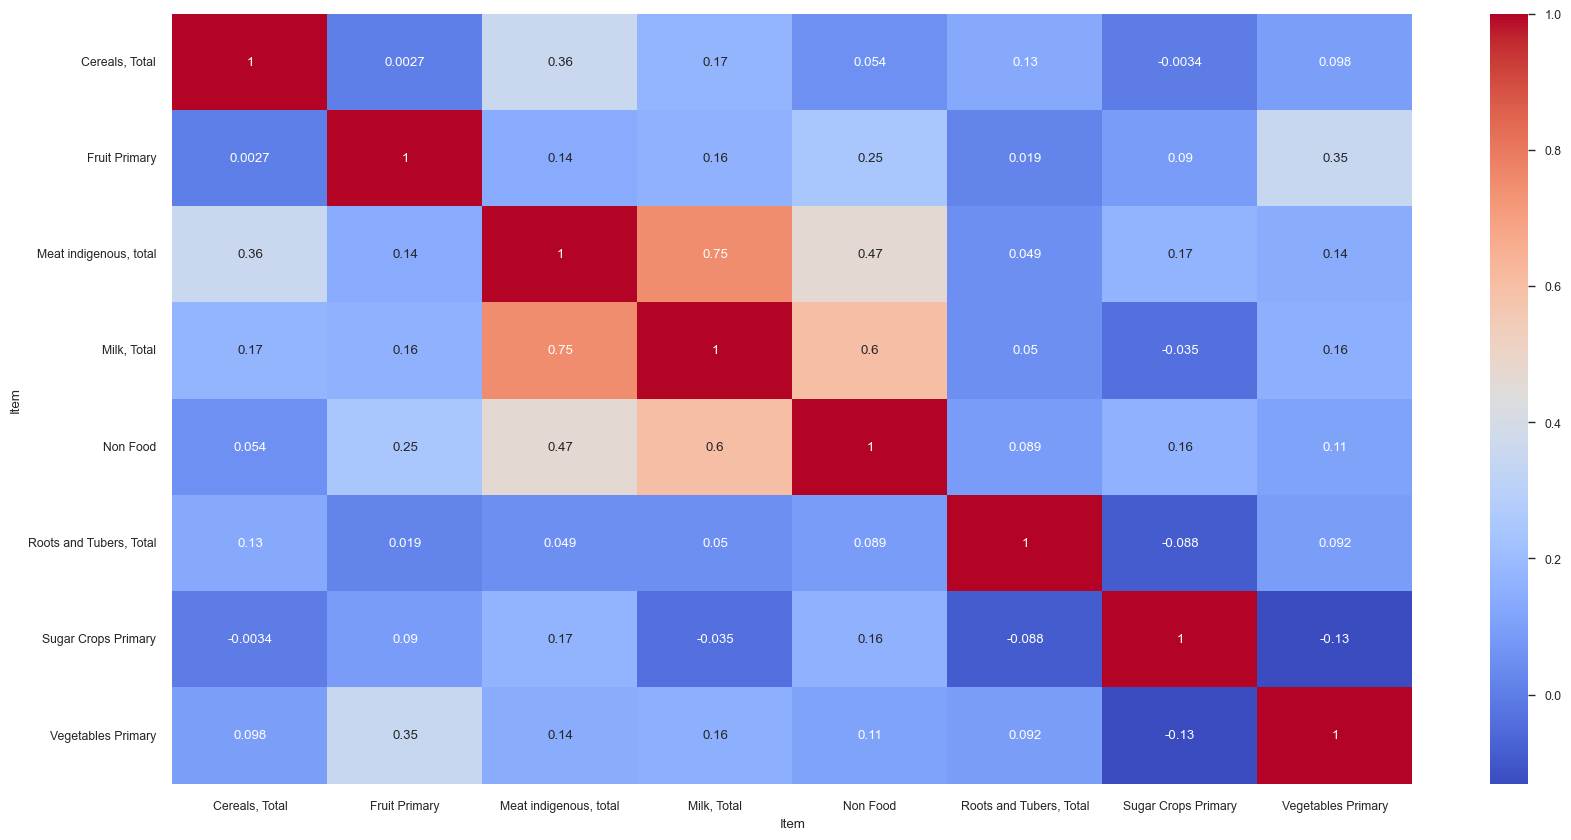

In [283]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(prod19_df.corr(),annot = True, cmap='coolwarm')
plt.show()

In [284]:
#featurewiz does not work for clustering or unsupervised problems
#pip install featurewiz --user

In [285]:
prod19_df.fillna(0, inplace=True)

In [286]:
prod19_df.set_index('Area', inplace=True)
prod19_df.head()

Item,"Cereals, Total",Fruit Primary,"Meat indigenous, total","Milk, Total",Non Food,"Roots and Tubers, Total",Sugar Crops Primary,Vegetables Primary
Area,,,,,,,,
Afghanistan,36.263282,49.876860,30.440250,24.313719,2.170455,6.103549,0.054991,12.133944
Albania,49.112995,155.545650,96.876247,167.844690,17.509759,22.699254,0.503500,151.655095
Algeria,29.452386,85.487778,64.256817,35.373773,3.959409,29.420493,0.000000,73.969390
Angola,18.371780,57.580569,30.352553,2.807108,1.636325,54.670691,1.040472,6.316054
Argentina,399.957873,106.359028,437.902230,96.165605,26.035053,15.776663,18.432147,30.400876


In [287]:
#https://www.kaggle.com/code/emilytries/clustering-and-feature-selection
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in prod19_df.columns:
    replace_with_thresholds(prod19_df, col)

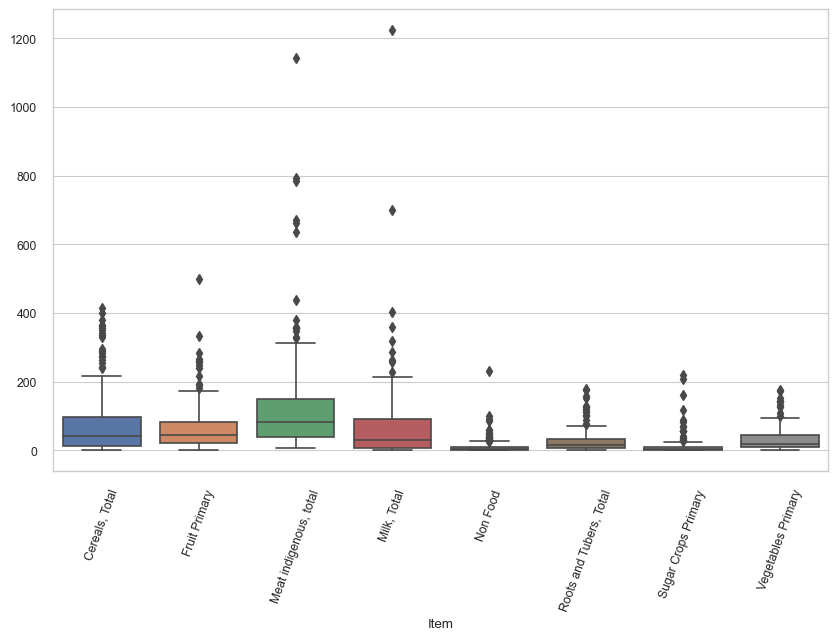

In [288]:
plt.figure(figsize=(10,6))
sns.boxplot(data=prod19_df)
plt.xticks(rotation=70)
plt.show()

In [289]:
def df_minmax(df):
    # Min Max Scaler
    sc = MinMaxScaler((0, 1))
    df_trans = sc.fit_transform(df)
    return pd.DataFrame(df_trans, columns=df.columns, index=df.index)

In [290]:
data19_scaled = df_minmax(prod19_df)
data19_scaled.head()

Item,"Cereals, Total",Fruit Primary,"Meat indigenous, total","Milk, Total",Non Food,"Roots and Tubers, Total",Sugar Crops Primary,Vegetables Primary
Area,,,,,,,,
Afghanistan,0.087325,0.099723,0.020852,0.019863,0.009415,0.033524,0.000250,0.058803
Albania,0.118268,0.312003,0.079314,0.137164,0.075953,0.126410,0.002287,0.857666
Algeria,0.070924,0.171263,0.050610,0.028902,0.017175,0.164029,0.000000,0.412857
Angola,0.044241,0.115199,0.020775,0.002287,0.007098,0.305354,0.004726,0.025491
Argentina,0.963128,0.213191,0.379410,0.078584,0.112934,0.087664,0.083722,0.163395


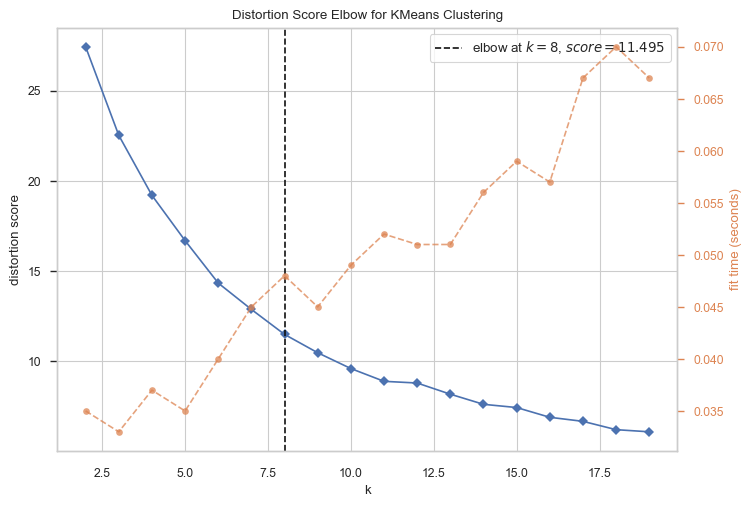

In [291]:
# KMeans Clustering
#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
#kmeans = KMeans()
#ssd = []
#K = range(1, 44)

#for k in K:
#    kmeans = KMeans(n_clusters=k).fit(data_scaled)
#    ssd.append(kmeans.inertia_)

#ssd

#plt.plot(K, ssd, "bx-")
#plt.xlabel("Distance Residual Sums for K Values (WCSS)")
#plt.title("Elbow Method for Optimum Number of Clusters")
#plt.show()

kmeans = KMeans()
fig = KElbowVisualizer(kmeans, k=(2, 20))
fig.fit(data19_scaled)
fig.show();

In [292]:
n_clusters=fig.elbow_value_
kmeans = KMeans(n_clusters).fit(data19_scaled)
clusters = kmeans.labels_

#pd.DataFrame({"Customers": prod19_df.index, "Clusters": clusters})
prod19_df["cluster_no"] = clusters
prod19_df.head()

Item,"Cereals, Total",Fruit Primary,"Meat indigenous, total","Milk, Total",Non Food,"Roots and Tubers, Total",Sugar Crops Primary,Vegetables Primary,cluster_no
Area,,,,,,,,,
Afghanistan,36.263282,49.876860,30.440250,24.313719,2.170455,6.103549,0.054991,12.133944,4
Albania,49.112995,155.545650,96.876247,167.844690,17.509759,22.699254,0.503500,151.655095,6
Algeria,29.452386,85.487778,64.256817,35.373773,3.959409,29.420493,0.000000,73.969390,3
Angola,18.371780,57.580569,30.352553,2.807108,1.636325,54.670691,1.040472,6.316054,4
Argentina,399.957873,106.359028,437.902230,96.165605,26.035053,15.776663,18.432147,30.400876,1


In [293]:
#prod19_df["cluster_no"] = prod19_df["cluster_no"] + 1
prod19_df.groupby("cluster_no").agg({"cluster_no": "count"})

Item,cluster_no
cluster_no,
0,9
1,20
2,21
3,26
4,82
5,1
6,9
7,4


In [294]:
prod19_df.groupby("cluster_no").agg(np.mean)

Item,"Cereals, Total",Fruit Primary,"Meat indigenous, total","Milk, Total",Non Food,"Roots and Tubers, Total",Sugar Crops Primary,Vegetables Primary
cluster_no,,,,,,,,
0,69.055111,73.714755,106.323556,58.790454,21.589219,137.297237,7.580678,41.064403
1,312.959396,76.512444,268.594670,133.023157,11.680716,36.297366,14.898640,34.912023
2,138.823035,30.522633,181.224201,106.108021,11.564101,22.915091,12.872077,22.891860
3,39.144716,135.087353,112.125007,53.577403,10.894077,21.226015,10.434845,58.487242
4,25.312216,36.396197,63.532166,30.734078,7.327180,17.364849,6.093852,15.198291
5,43.675442,258.049854,1143.134127,1223.618650,230.533608,26.762470,0.000000,70.813388
6,71.732759,124.587464,152.576201,113.349199,12.281308,27.575177,4.397956,143.832514
7,48.389479,78.173926,165.396330,22.814657,10.874977,9.059685,176.177033,12.598229


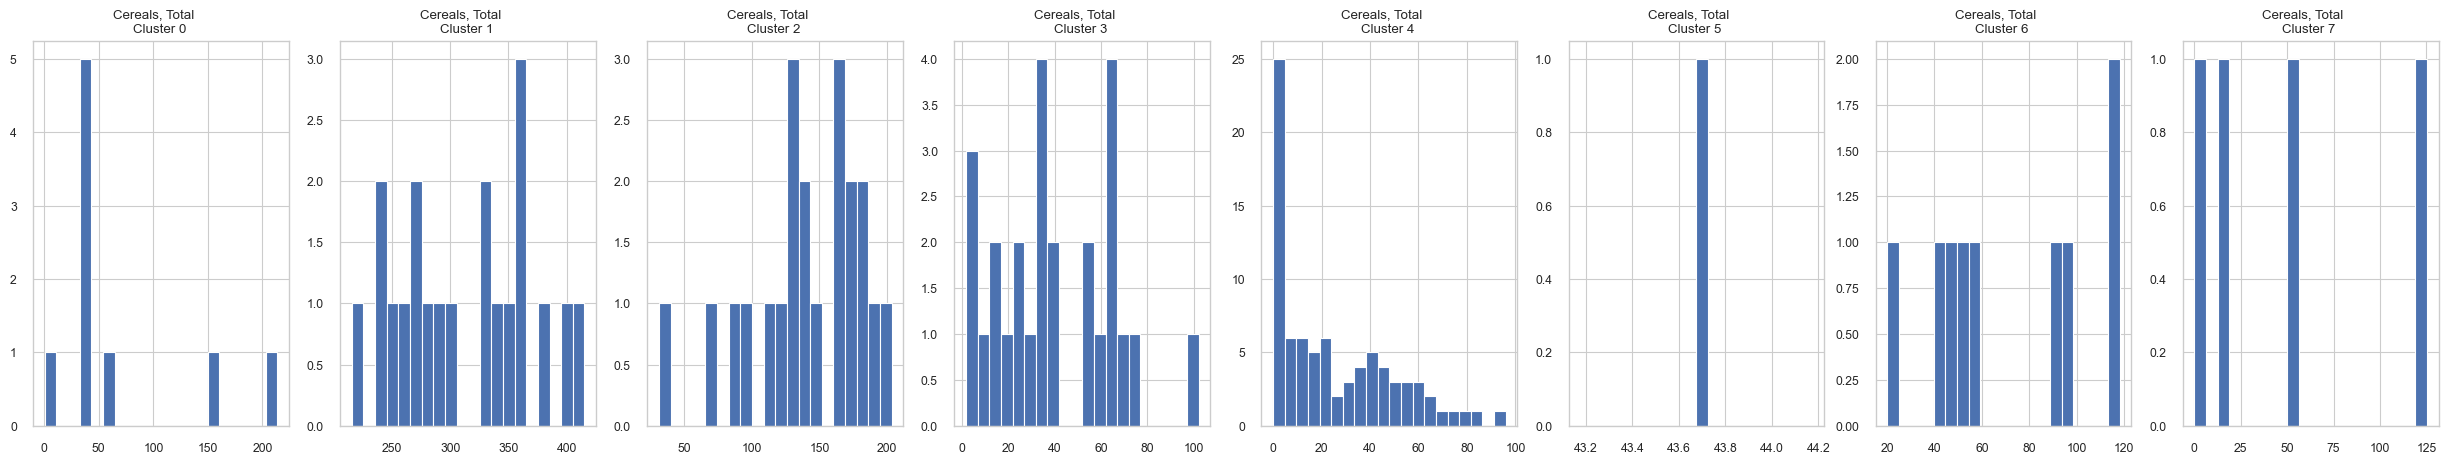

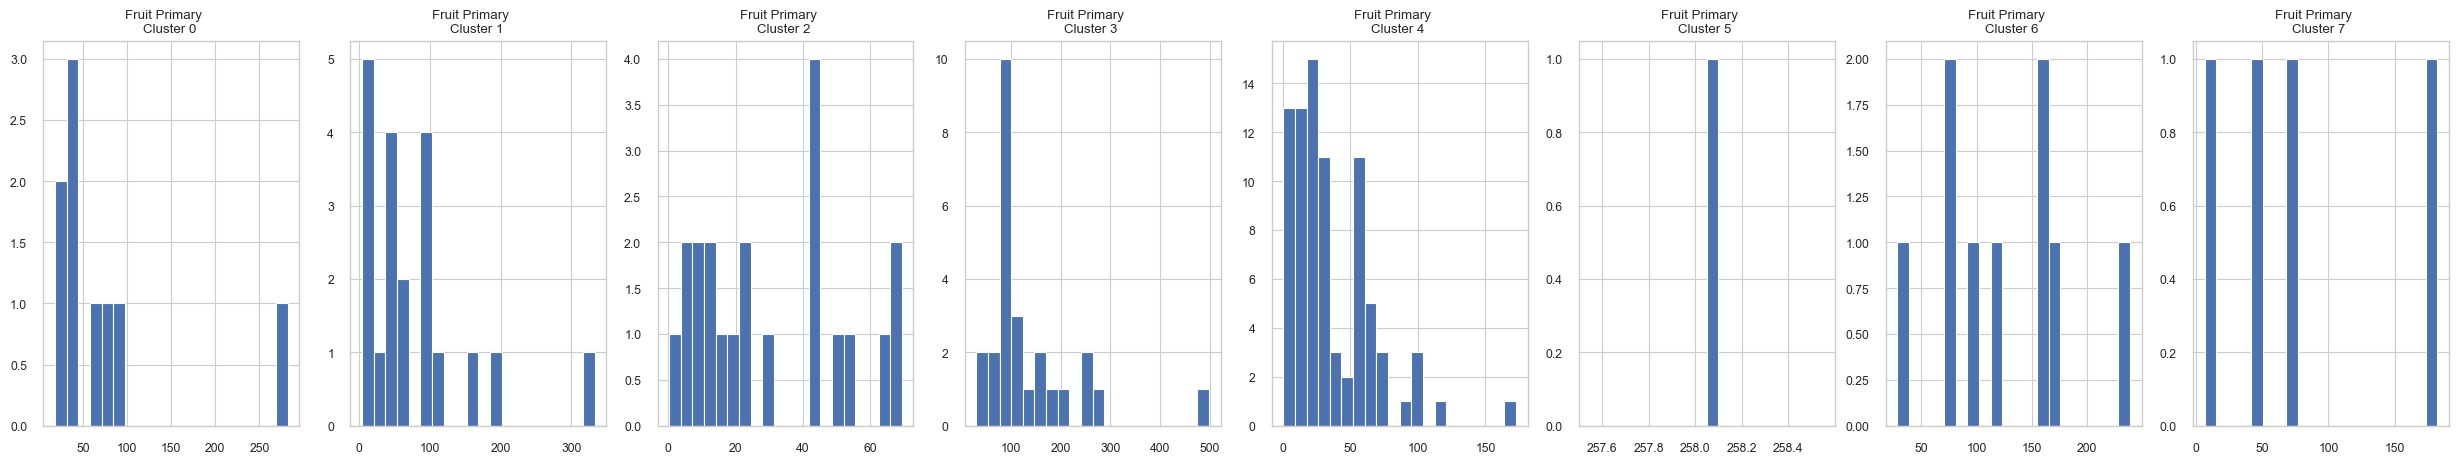

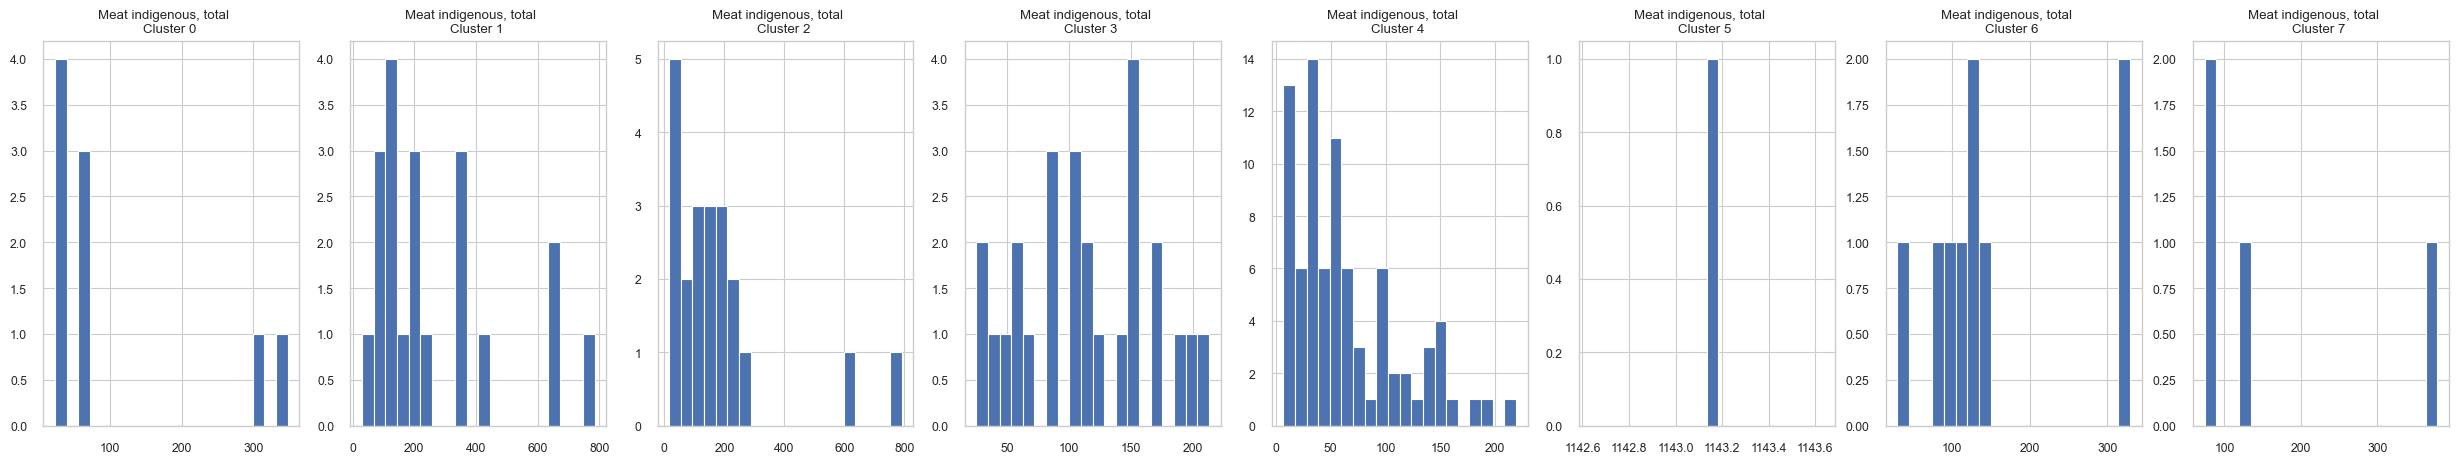

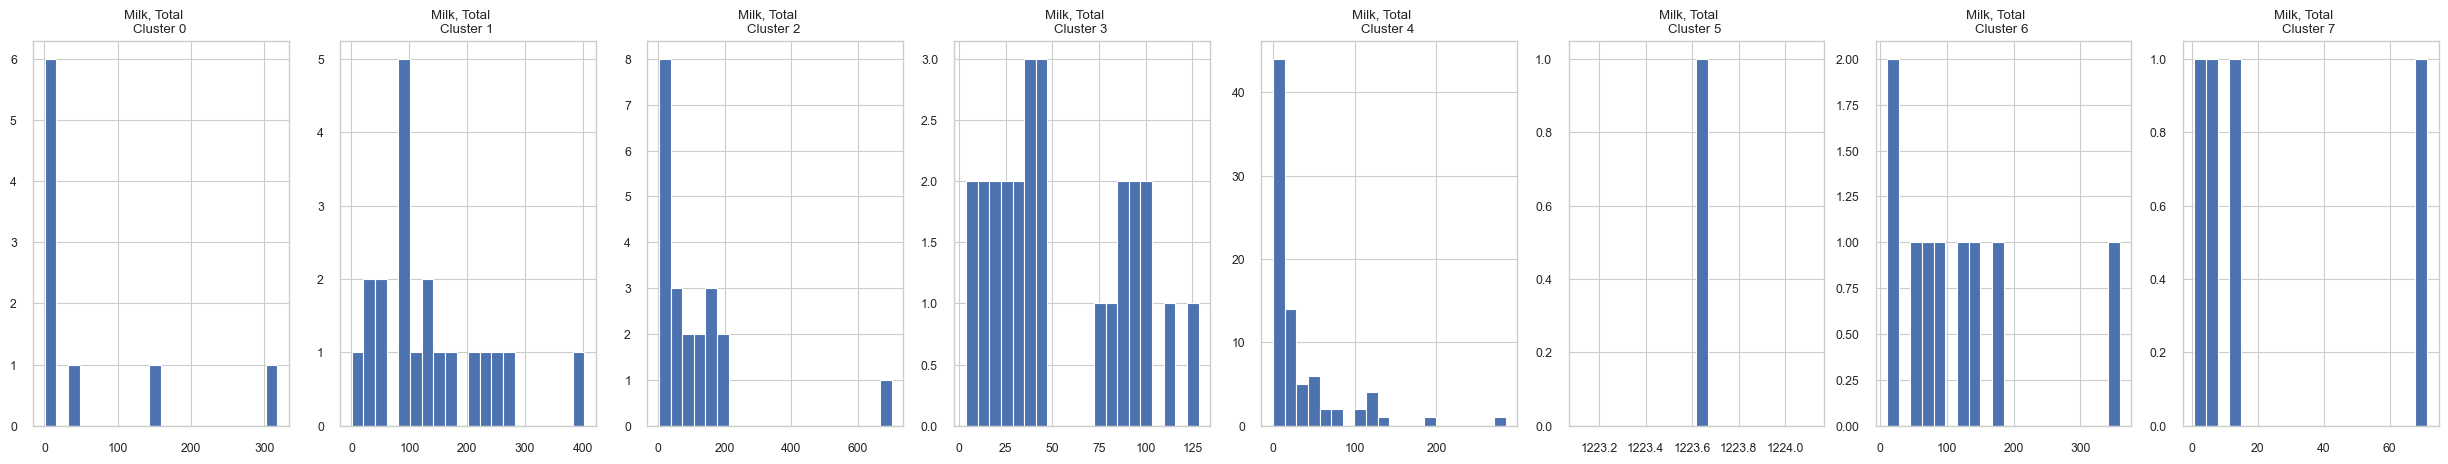

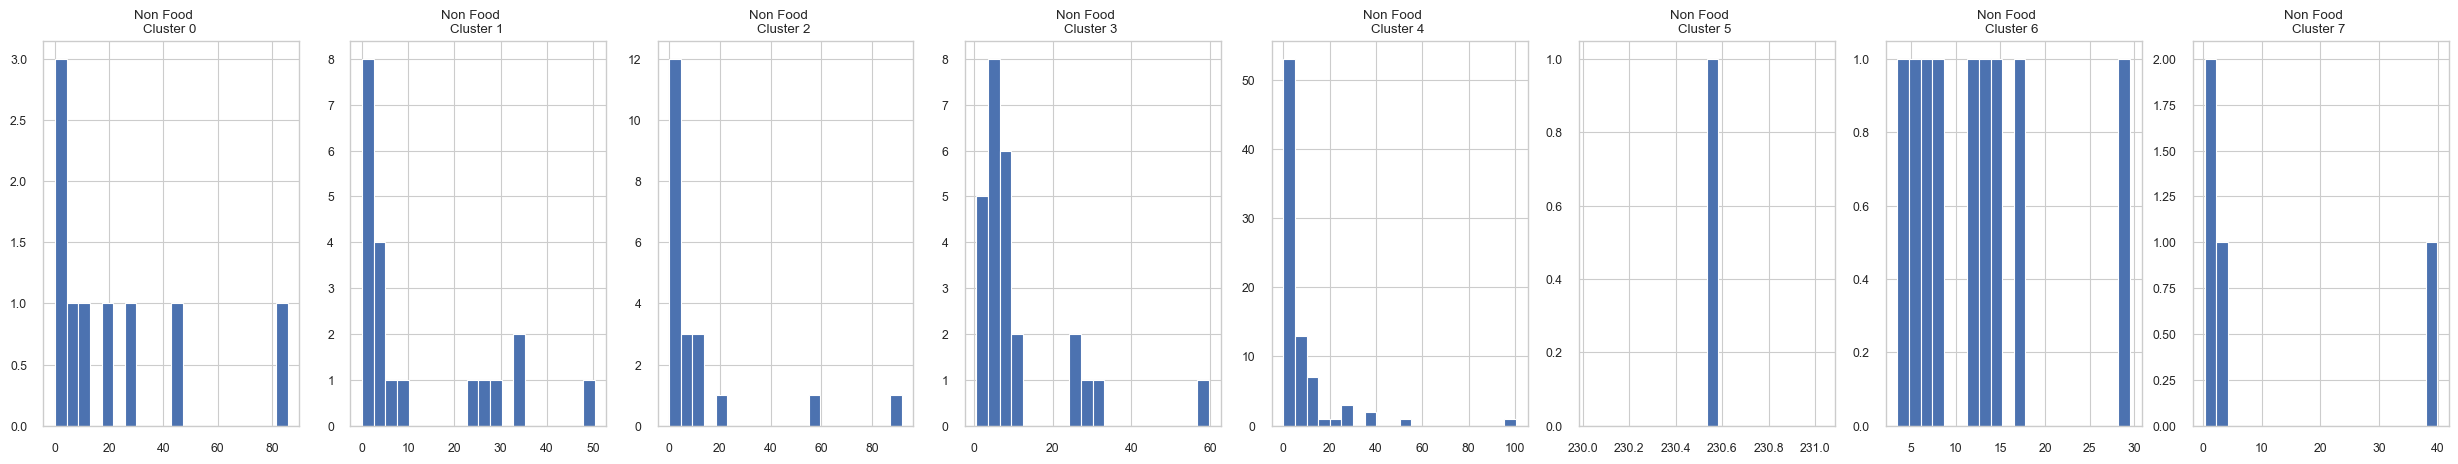

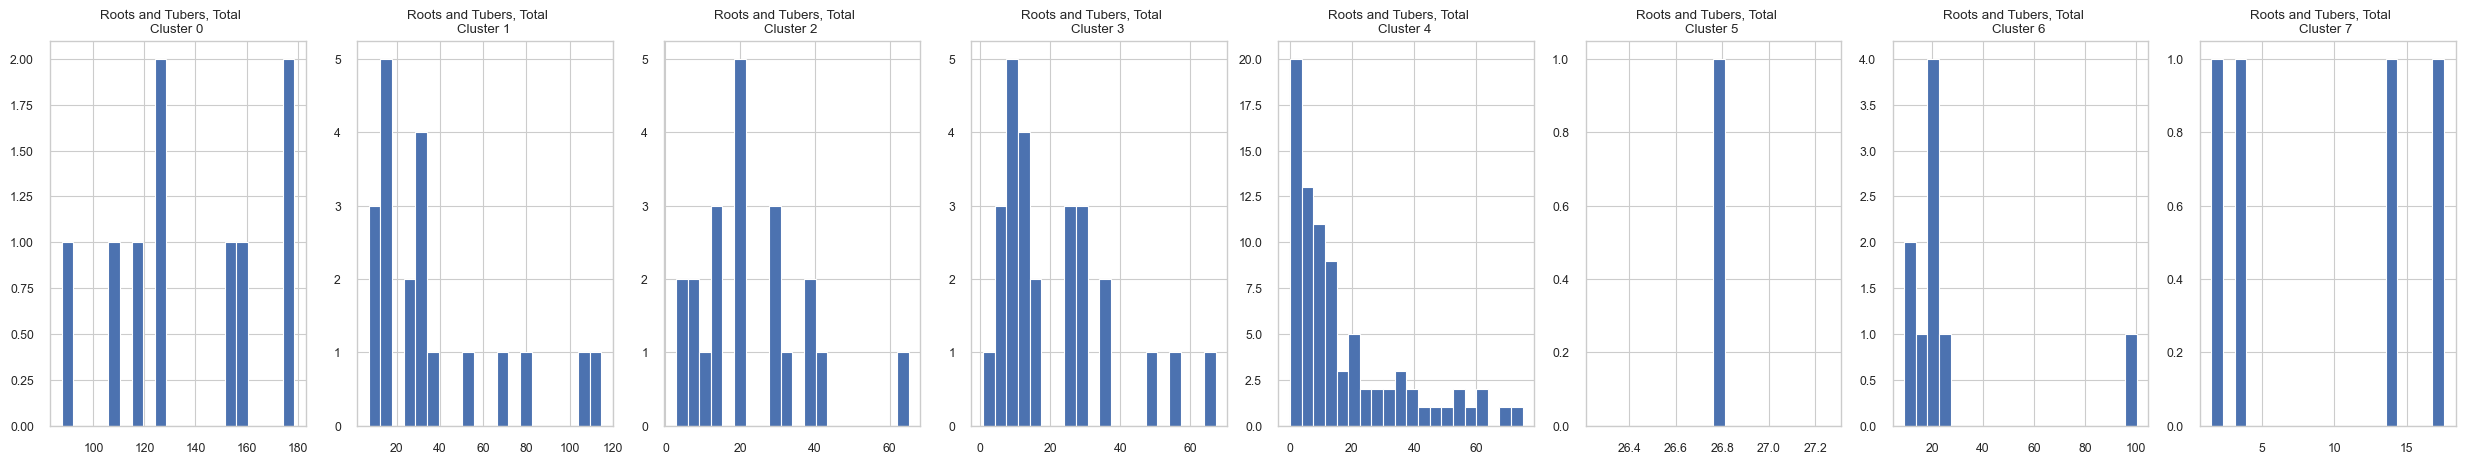

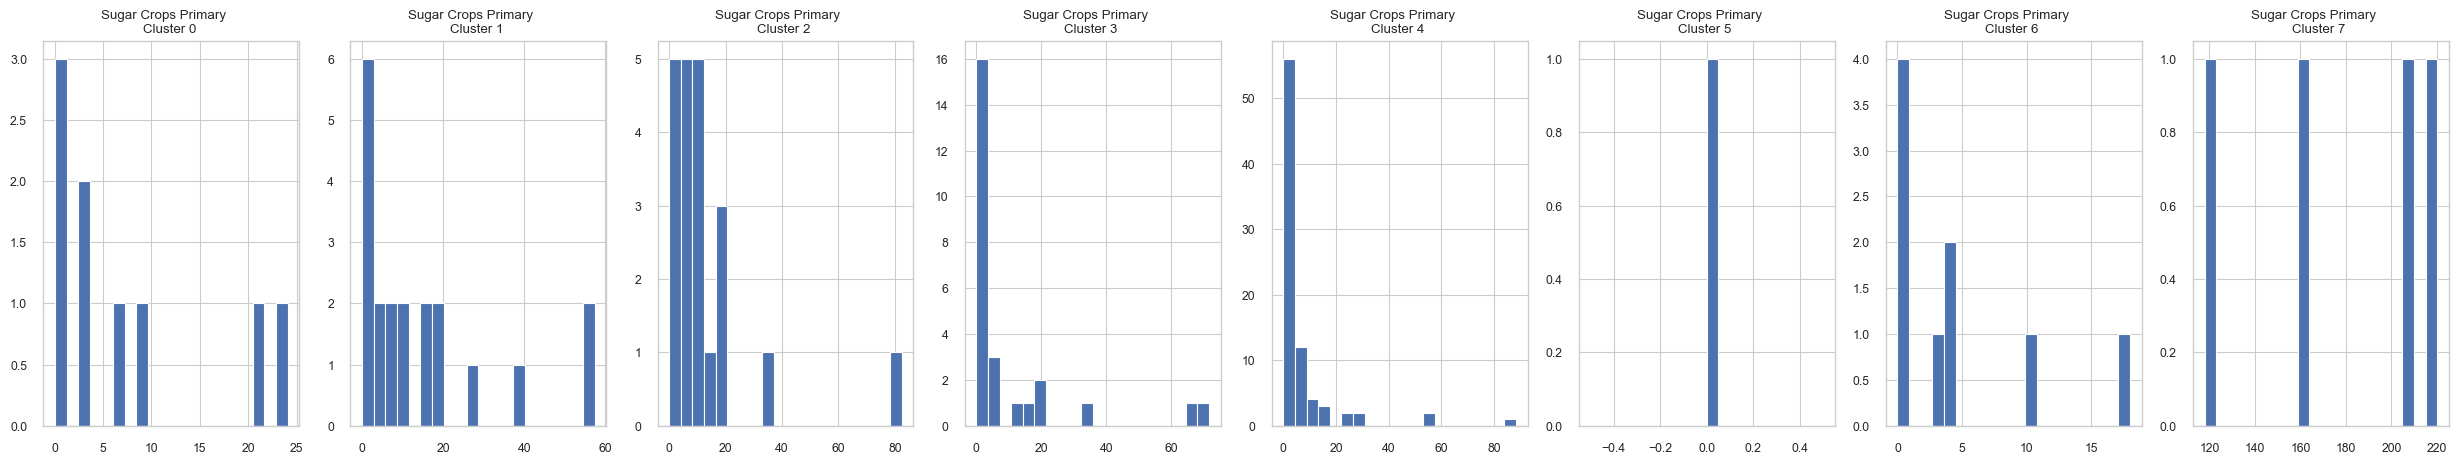

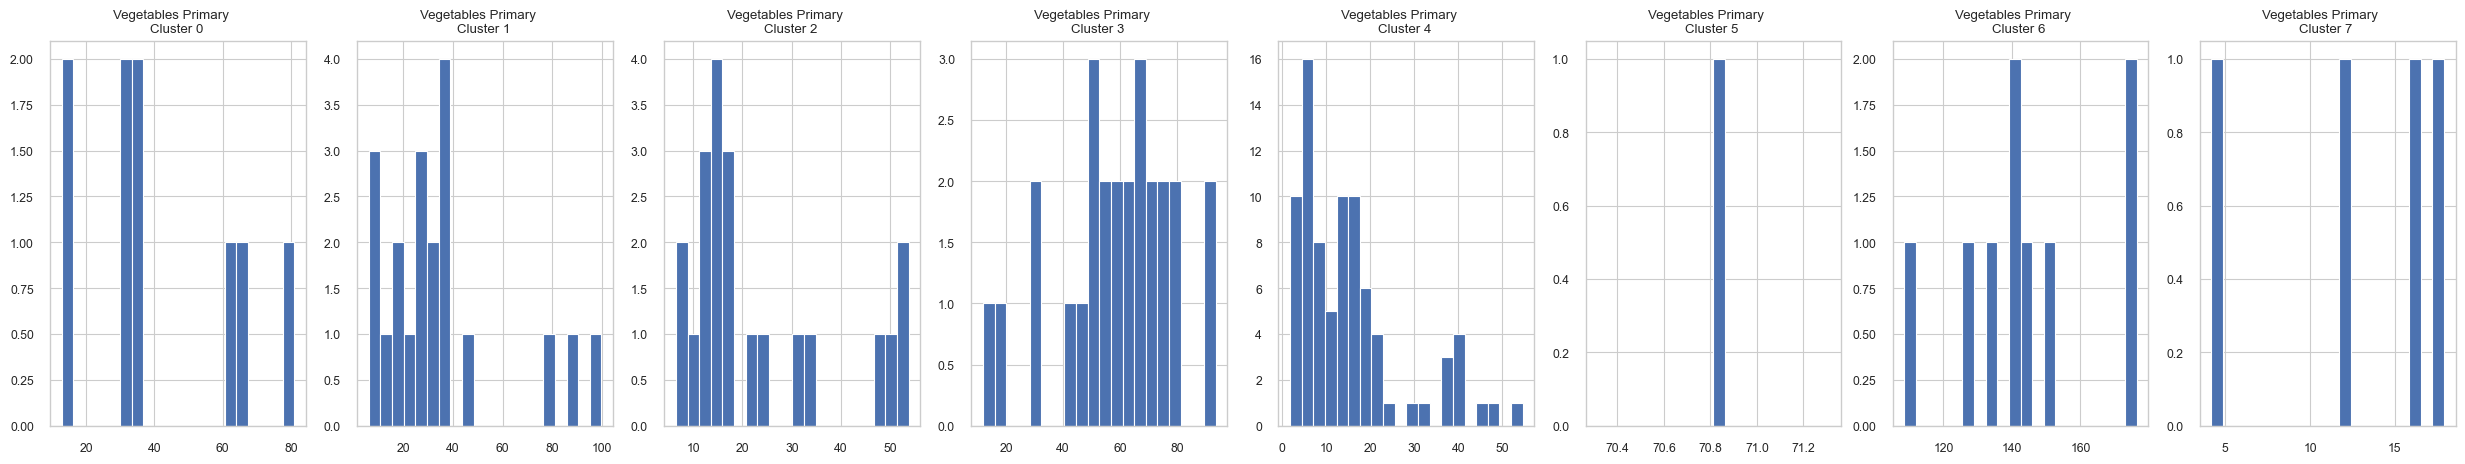

In [295]:
for i in prod19_df.columns:
    if i != 'cluster_no':
        plt.figure(figsize = (35, 5))
        for j in range(1,n_clusters+1):
            plt.subplot(1,n_clusters+1,j+1)
            cluster = prod19_df[prod19_df['cluster_no'] == j-1]
            cluster[i].hist(bins = 20)
            plt.title('{}    \nCluster {} '.format(i,j-1))
  
    plt.show()

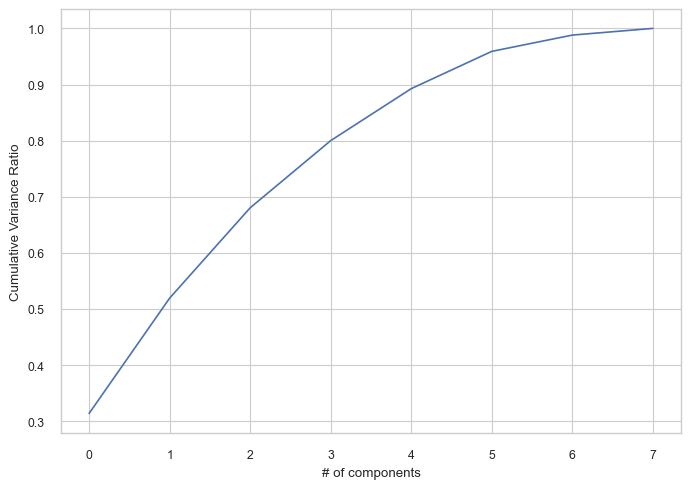

In [296]:
pca = PCA().fit(data19_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("# of components")
plt.ylabel("Cumulative Variance Ratio")
plt.show()

In [297]:
for i in range(prod19_df.shape[1]):
    pca = PCA(n_components=i)
    pca_fit = pca.fit_transform(data19_scaled)
    print(i, pca.explained_variance_ratio_.sum())

0 0.0
1 0.3141818512334256
2 0.5195256476372975
3 0.6804101254425531
4 0.8000971860709748
5 0.8926267488209028
6 0.9590414966308767
7 0.9880694517456606
8 1.0


In [298]:
#Only for easy visualization, we pick 2 variables.
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(data19_scaled)
pca.explained_variance_ratio_

array([0.31418185, 0.2053438 ])

In [299]:
# Convert to a data frame
X_reduceddf = pd.DataFrame(pca_fit, index=data19_scaled.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = clusters
X_reduceddf.head()

,PC1,PC2,cluster
Area,,,
Afghanistan,-0.192441,-0.085735,4
Albania,0.164829,0.658966,6
Algeria,-0.050845,0.254653,3
Angola,-0.180009,-0.057812,4
Argentina,0.733493,-0.289497,1


In [300]:
#https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/functions.py
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)
            
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=sns.color_palette("Paired"))

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

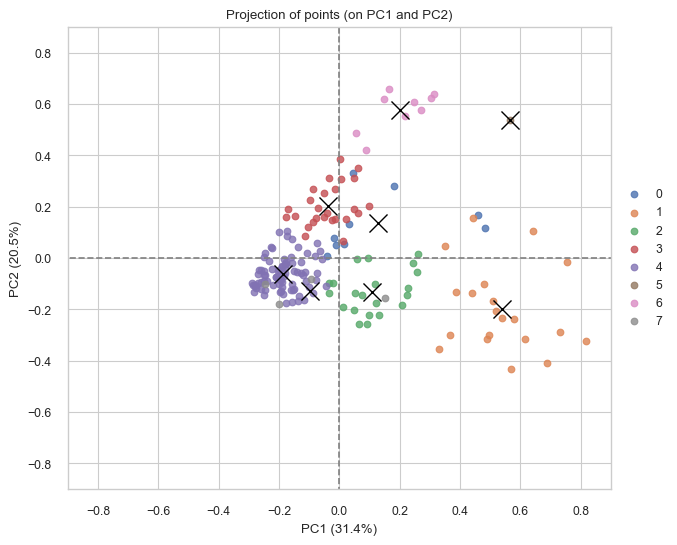

In [301]:
from sklearn.decomposition import PCA
centres_reduced = pca.transform(kmeans.cluster_centers_);
display_factorial_planes(pca_fit, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8);
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=1,
            color='black', zorder=10);

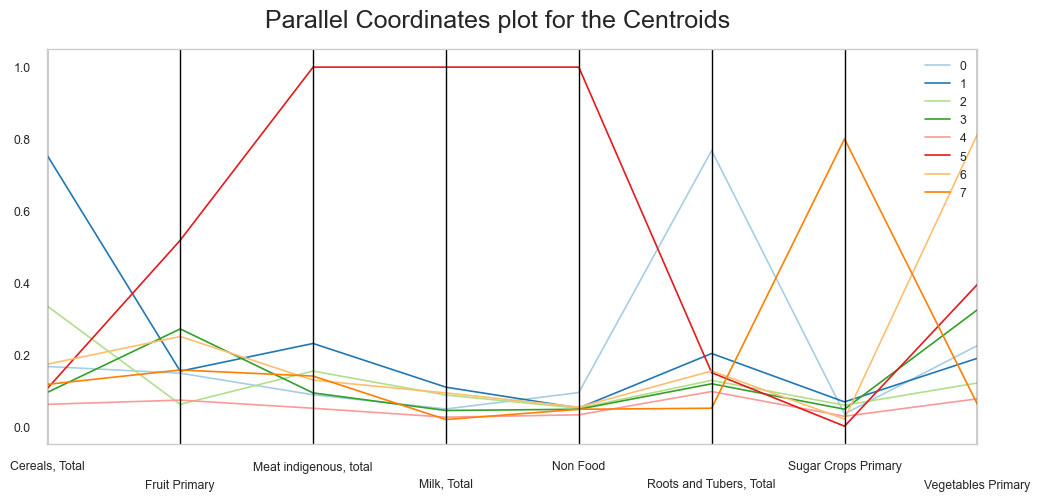

In [302]:
from pandas.plotting import parallel_coordinates
palette = sns.color_palette("bright", 10)


# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(data19_scaled, index=data19_scaled.index, columns=data19_scaled.columns)
X_clustered["cluster"] = clusters
means =  X_clustered.groupby(by="cluster").mean()
display_parallel_coordinates_centroids(means.reset_index(), 5)

In [303]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations");
print(get_top_abs_correlations(data19_scaled, 5));

Top Absolute Correlations
Item                     Item       
Meat indigenous, total   Milk, Total    0.781458
Cereals, Total           cluster        0.597325
Milk, Total              Non Food       0.508540
Roots and Tubers, Total  cluster        0.493033
Meat indigenous, total   Non Food       0.467034
dtype: float64


In [306]:
codes_df = pd.read_csv(pop_folder /"Population_E_AreaCodes.csv", encoding = 'unicode_escape');
prod19_df=prod19_df.merge(codes_df, on='Area', how='left');

cc = coco.CountryConverter();
prod19_df['iso']=cc.pandas_convert(prod19_df['Area'], to='ISO3');

In [307]:
import plotly.express as px

In [308]:
fig = px.choropleth(prod19_df, 
                    locations=prod19_df['iso'], 
                    color="cluster_no",
                     hover_name="cluster_no",
                    labels={'cluster_no':'Cluster'},
                    title='foo',
                    color_continuous_scale=px.colors.sequential.Plasma,
                   )
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(title_text='Map of countries clustered by production behavior',title_x = 0.4, title_y=0.9,margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [309]:
cluster_ire=prod19_df['cluster_no'][prod19_df['Area']=='Ireland'].values[0]
print("Regions in the same cluster than Ireland: \n")
#use to_string function to remove the "Name", "Dtype" from the output. 
print(prod19_df['Area'][prod19_df['cluster_no']==cluster_ire].to_string(index=False))

Regions in the same cluster than Ireland: 

                                           Austria
                                        Bangladesh
                  Bolivia (Plurinational State of)
                                           Croatia
                                           Czechia
                                           Finland
                                           Germany
                                            Guinea
                                           Ireland
                                              Mali
                                          Mongolia
                                           Myanmar
                                             Nepal
                                            Poland
                                Russian Federation
                                          Slovakia
                                          Suriname
                                            Sweden
                                      

In [310]:
prod19_df[prod19_df['cluster_no']==cluster_ire].head()

,Area,"Cereals, Total",Fruit Primary,"Meat indigenous, total","Milk, Total",Non Food,"Roots and Tubers, Total",Sugar Crops Primary,Vegetables Primary,cluster_no,Area Code,M49 Code,iso
7,Austria,129.367090,51.851814,244.388476,179.420920,1.280076,21.173229,10.425859,23.984622,2,11.0,'040,AUT
10,Bangladesh,134.773630,14.964878,16.057212,9.966002,7.549592,14.893519,0.906715,14.477892,2,16.0,'050,BGD
17,Bolivia (Plurinational State of),70.090848,53.810822,216.151304,21.762261,7.228812,30.259019,36.428337,13.757975,2,19.0,'068,BOL
37,Croatia,176.956147,43.789797,124.603124,62.397209,4.544099,10.493124,8.083294,12.333186,2,98.0,'191,HRV
40,Czechia,161.736440,12.421429,104.916441,125.320221,0.075354,14.787882,16.370515,6.474598,2,167.0,'203,CZE


In [311]:
#prod_wide=pd.wide_to_long(prod_df, stubnames='Y', i=['Area', 'Item'], j='Year').reset_index()

In [312]:
prod_clust=prod_df

In [313]:
countries_ire = prod19_df["Area"][prod19_df['cluster_no']==cluster_ire].unique()

In [314]:
def select_countries_cluster(country, country_list, max_num):
    if (len(country_list)<= max_num):
        return country_list
    else:
        country_list.remove(country)
        sample_list=[country]
        sample_list+=random.sample(country_list, max_num-1)
        return sorted(sample_list)

In [315]:
sample_countries=select_countries_cluster('Ireland', list(countries_ire), 10)

In [316]:
prod_clust = prod_clust[prod_clust["Area"].isin(sample_countries)]
prod_clust = prod_clust[prod_clust["Item"].isin(['Cereals, Total','Fruit Primary',
                                    'Meat indigenous, total','Milk, Total',
                                    'Non Food','Roots and Tubers, Total',
                                    'Sugar Crops Primary','Vegetables Primary'])]
prod_clust = prod_clust[(prod_clust["Year"]>=1999) & (prod_clust["Year"]<=2019)]

In [317]:
prod_clust= prod_clust.merge(pop_df[["Area", "Year", "Total_Population"]], how='left', on=['Area', 'Year'])
prod_clust["Prod_pop"]=prod_clust["Total_Prod"]/prod_clust["Total_Population"]

In [318]:
#create_report(prod_wide).show_browser()

In [319]:
#STREAMLIT APP

for item in prod_wide['Item'].unique():
    fig = plt.figure(figsize=(8,7))
    plt.title(item)
    sns.lineplot(data=prod_wide[prod_wide['Item']==item].drop('Item', axis=1), x='Year', y='Y', hue='Area')
    st.pyplot(fig)

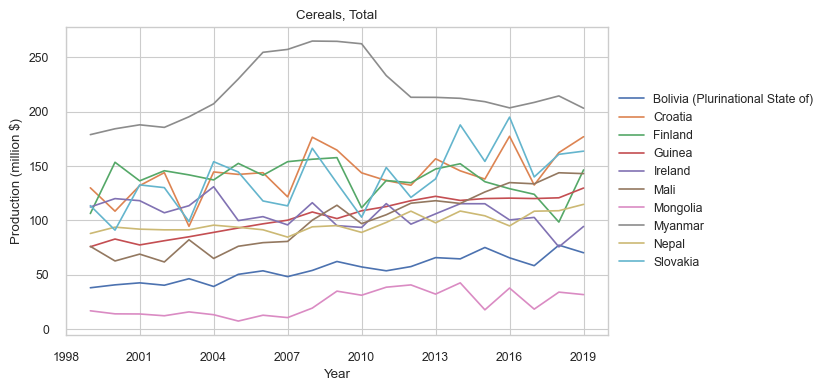

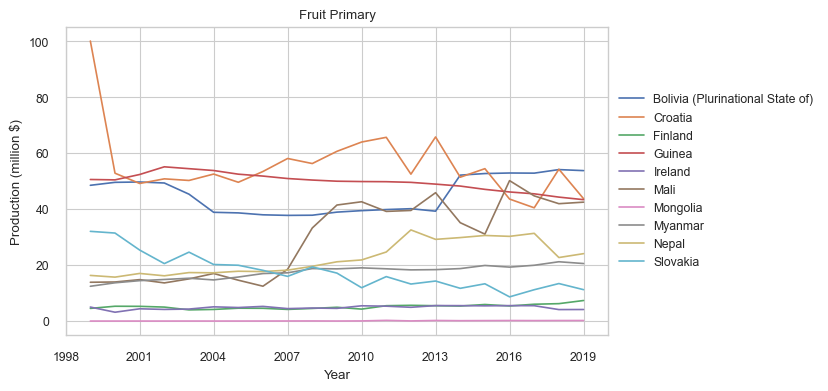

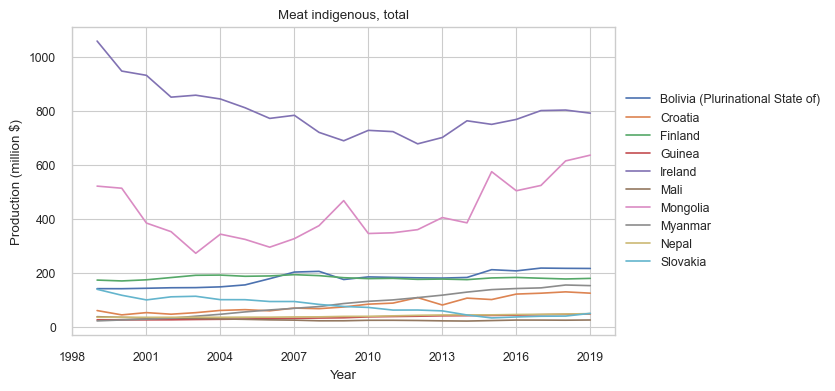

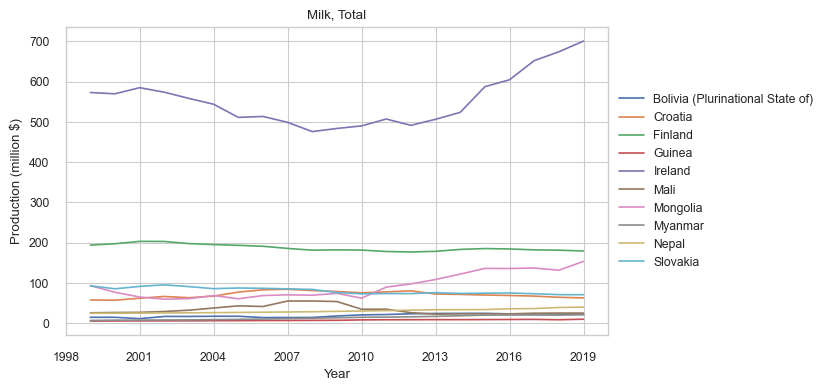

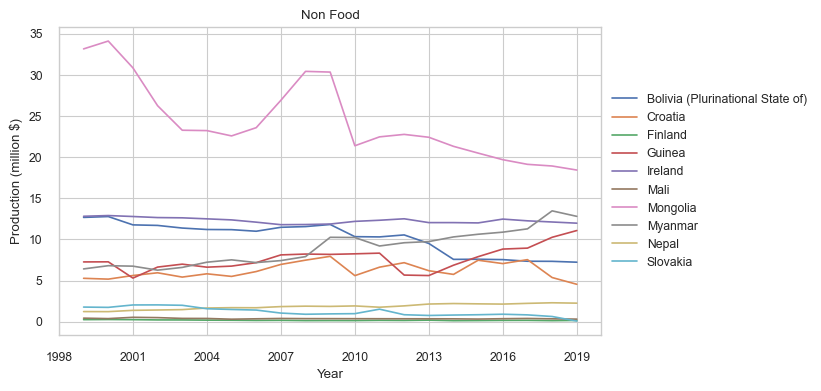

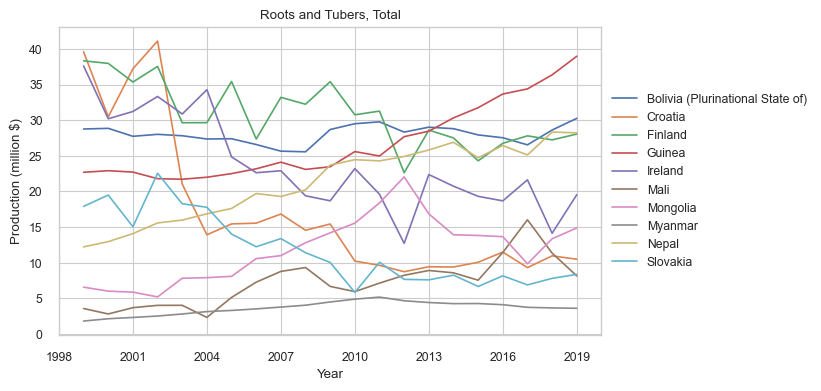

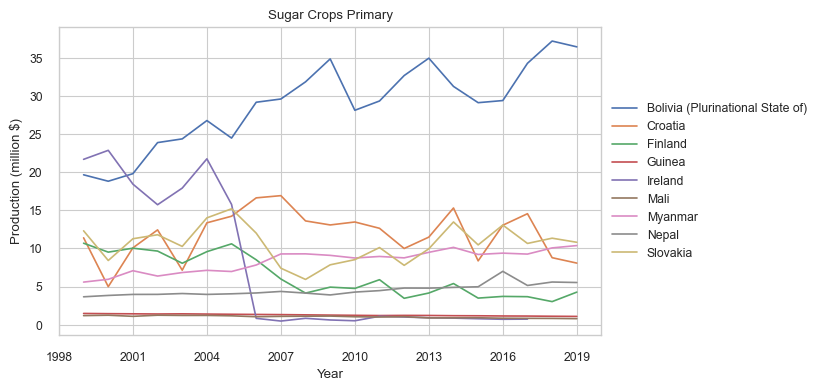

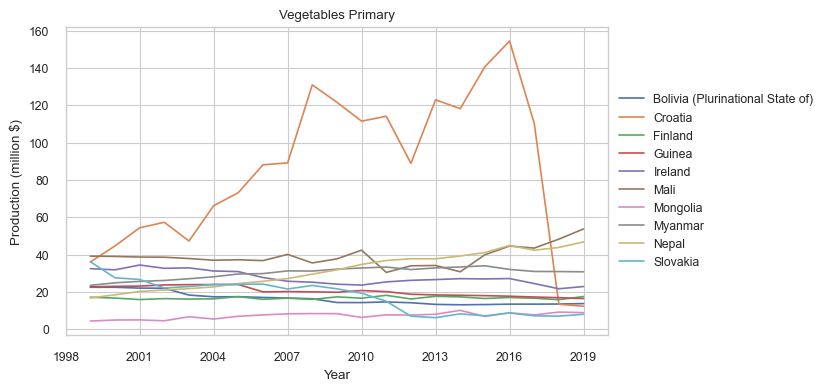

In [320]:
for item in prod_clust['Item'].unique():
    fig = plt.figure(figsize=(7,4))
    ax = plt.subplot(111)
    plt.title(item)
    sns.lineplot(data=prod_clust[prod_clust['Item']==item].drop('Item', axis=1), x='Year', y='Prod_pop', hue='Area')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Production (million $)')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show(fig)

In [321]:
prod_clust.head()

,Area,Item,Year,Total_Prod,Total_Population,Prod_pop
0,Bolivia (Plurinational State of),"Cereals, Total",1999,319239.0,8439.052,37.828775
1,Bolivia (Plurinational State of),"Cereals, Total",2000,348102.0,8592.656,40.511572
2,Bolivia (Plurinational State of),"Cereals, Total",2001,370413.0,8746.084,42.351869
3,Bolivia (Plurinational State of),"Cereals, Total",2002,357410.0,8900.583,40.155797
4,Bolivia (Plurinational State of),"Cereals, Total",2003,418263.0,9057.378,46.179259


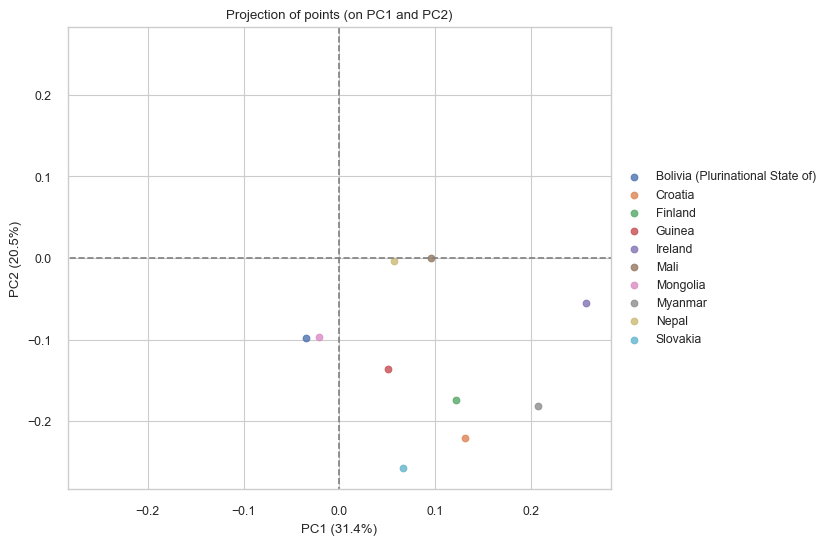

In [322]:
from sklearn.decomposition import PCA
centres_reduced = pca.transform(kmeans.cluster_centers_);
display_factorial_planes(pca_fit[prod19_df['Area'].isin(list(prod_clust['Area']))], 2, pca, [(0,1)], illustrative_var = prod19_df['Area'][prod19_df['Area'].isin(list(prod_clust['Area']))], alpha = 0.8);

In [323]:
ire_df=prod_df[prod_df['Area']=='Ireland'].pivot(index='Year', columns='Item', values='Total_Prod')
aus_df=prod_df[prod_df['Area']=='Austria'].pivot(index='Year', columns='Item', values='Total_Prod')

In [324]:
def test_normality(df, pvalue, model='shapiro'):
    print("\nNormal variables following", model, "Test:\n")
    for col in df.columns:
        result=getattr(stats,model)(df[col])
        if result[1] > pvalue and not math.isnan(result[0]):
            print("   ",col, round(result[0],4), round(result[1],4))
        

In [325]:
test_normality(ire_df, 0.05, 'shapiro')


Normal variables following shapiro Test:

    Barley 0.9716 0.1744
    Crops 0.9653 0.0854
    Fruit Primary 0.9631 0.0667
    Non Food 0.9747 0.2472
    Peas, dry 0.9697 0.1403
    Shorn wool, greasy, including fleece-washed shorn wool 0.9726 0.1955


In [326]:
test_normality(aus_df, 0.05, 'shapiro')


Normal variables following shapiro Test:

    Apples 0.9852 0.678
    Barley 0.9625 0.0622
    Crops 0.9631 0.067
    Fruit Primary 0.9706 0.1569
    Natural honey 0.9686 0.1245
    Peaches and nectarines 0.9665 0.0984
    Pears 0.9649 0.0816
    Peas, green 0.9799 0.4256
    Sugar Crops Primary 0.9846 0.651
    Sugar beet 0.9846 0.651
    Vegetables Primary 0.9726 0.1962
    Vegetables and Fruit Primary 0.964 0.0739
    Wheat 0.9765 0.2979


In [327]:
#Selecting Barley as article in both countries as it is normal.
prod='Barley'
prod_country1=ire_df[prod]
prod_country2=aus_df[prod]

In [328]:
print(prod_country1.describe(),"\n")
print(prod_country2.describe())

count        60.000000
mean     232059.466667
std       65067.912474
min      100413.000000
25%      190252.750000
50%      238282.000000
75%      282985.000000
max      344842.000000
Name: Barley, dtype: float64 

count        60.000000
mean     199096.766667
std       54488.174641
min       99667.000000
25%      162361.000000
50%      193203.000000
75%      238531.250000
max      296410.000000
Name: Barley, dtype: float64


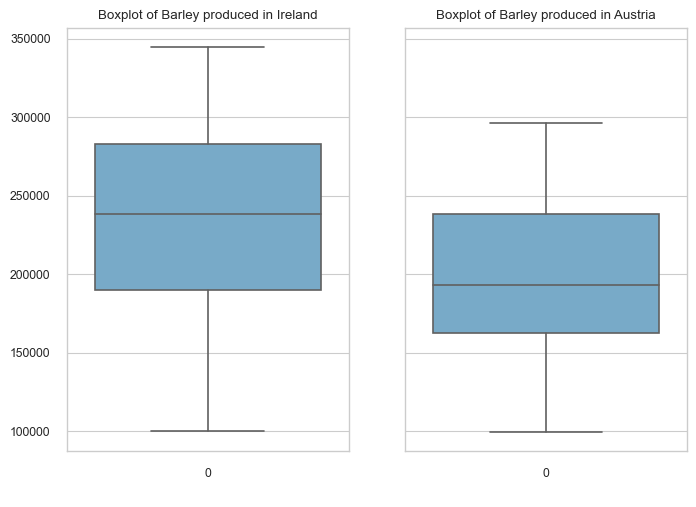

In [329]:
fig, ax =plt.subplots(1,2, sharey=True);

sns.boxplot(data=prod_country1.reset_index()[prod], palette="Blues", ax=ax[0]);
sns.boxplot(data=prod_country2.reset_index()[prod], palette="Blues", ax=ax[1]);

ax[0].set_title('Boxplot of ' + prod + ' produced in Ireland');
ax[1].set_title(str('Boxplot of '+ prod +' produced in Austria'));

for i in ax.flat:
    i.set(xlabel=' ');
    
plt.show();

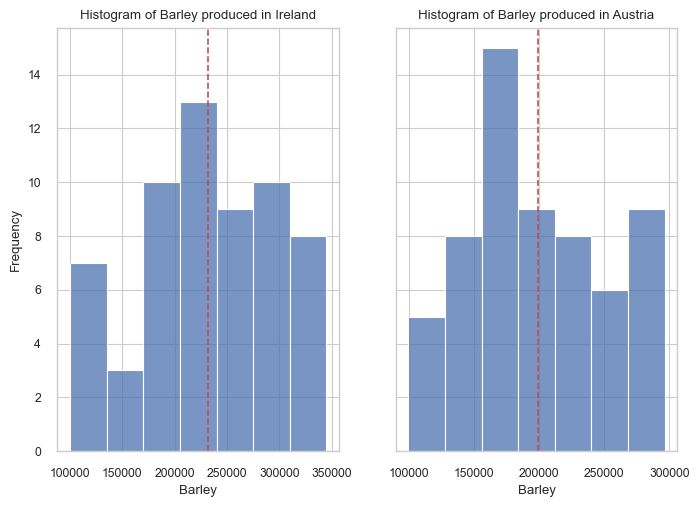

In [330]:
fig, ax =plt.subplots(1,2, sharey=True)

# Plot histograms
sns.histplot(prod_country1, ax=ax[0]);
sns.histplot(prod_country2, ax=ax[1]);

# Set plot titles
ax[0].set_title('Histogram of ' + prod + ' produced in Ireland')
ax[1].set_title(str('Histogram of '+ prod +' produced in Austria'))

# Set y-axis labels
for i in ax.flat:
    i.set(ylabel='Frequency')

# Add vertical lines for the mean
ax[0].axvline(prod_country1.mean(), color='r', linestyle='--')
ax[1].axvline(prod_country2.mean(), color='r', linestyle='--')

plt.show()

In [331]:
#Checking variances with Levene Homogeinity of variance: Levene's test

stats.levene(prod_country1, prod_country2, center = 'mean')

LeveneResult(statistic=1.27154338197908, pvalue=0.2617650005503895)

In [332]:
#H0 = variance are homogeneous
#H1 = variance are not homogeneous
#pvalue > 0.05 -> we do not reject the null hypothesis. There is not sufficient proof to say that the variances are not homogeneos. 

In [333]:
ire_df2=ire_df
ire_df2['Country']='Ireland'
aus_df2=aus_df
aus_df2['Country']='Austria'

a=ire_df2[['Barley', 'Country']].reset_index()
b=aus_df2[['Barley', 'Country']].reset_index()

#We perform ANOVA

model = ols('Barley~Country', data = pd.concat([a,b])).fit()
aov = sm.stats.anova_lm(model, type = 2)
print(aov)

             df        sum_sq       mean_sq         F   PR(>F)
Country     1.0  3.259619e+10  3.259619e+10  9.050984  0.00321
Residual  118.0  4.249649e+11  3.601397e+09       NaN      NaN


In [334]:
#If the PR(>F) value is less than 0.05, it can be concluded that there is a significant difference between the means of the groups, and that this difference is not due to chance. On the other hand, if the PR(>F) value is greater than 0.05, it cannot be concluded that there is a significant difference between the means of the groups.